# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

### Exercise 04.1

The NSL_SIMULATOR code we have provided compute the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, and the temperature, $T$.

<span style="color:red">Include the calculation of the pressure, $P$, inside your Molecular Dynamics code: block averages, progressive average values and progressive uncertainties.</span>

Remember that, via the **virial theorem**, the pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B \langle T \rangle + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

All'interno del file system.cpp ho aggiunto il calcolo della pressione lungo il corso della simulazione nel seguente modo. Per prima cosa ogni volta che viene applicata la funzione measure() viene fatto un ciclo sulle coppie di particelle e viene fatta la somma di:

$$ \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] $$

tramite il seguente pezzo di codice:

```cpp
if (_measure_pressure) {
  for (int i=0; i<_npart-1; i++){
    for (int j=i+1; j<_npart; j++){
      distance(0) = this->pbc( _particle(i).getposition(0,true) - _particle(j).getposition(0,true), 0);
      distance(1) = this->pbc( _particle(i).getposition(1,true) - _particle(j).getposition(1,true), 1);
      distance(2) = this->pbc( _particle(i).getposition(2,true) - _particle(j).getposition(2,true), 2);
      dr = sqrt( dot(distance,distance) );
      if(dr < _r_cut){
        // PRESSURE
        if(_measure_pressure) pressure_temp += 1.0/pow(dr,12) - 0.5/pow(dr,6); // PRESSURE
      }
    }
  }
}
```

Dopodichè questa sommatoria viene moltiplicata per le apposite costanti (come il volume e la densità):

```cpp
if (_measure_pressure and _measure_temp and _measure_kenergy){
  _measurement(_index_pressure) = _ptail + _rho*_measurement(_index_temp) + (48.0/(3.0*_volume))*pressure_temp;
} 
```

Per ogni step MC quetso valore viene sommato cumulativamente e poi nella funzione averages() viene effettuata la media sul numero di step così da ottenere la stima desiderata all'interno del blocco.

### Exercise 04.2

By means of your upgraded code, <span style="color:red">perform MD simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained progressive average values and uncertainties as a functions of the increasing number of blocks for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$, in reduced units!

### <span style="color:green"> Equilibration is needed!</span>

By monitoring the temperature, $T$, during the first time steps of the simulation, you will observe that at the beginning, starting from a perfect crystalline configuration, $T$ will not conserve its value. Can you understand and explain this behaviour?

Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$. <span style="color:red">Perform your solid/liquid/gas phase MD simulations by re-starting them after such equilibration time.</span>

Ho effettuato un'analisi per l'equilibrazione della temperatura. Ho ciclato su alcune temperature in cui ho individuato esserci quella di mio interesse perchè il sistema arrivasse a regime alla $T_{target}$. Ho utilizzato 10 blocchi da 1000 step per ciascuna fase e ho quindi individuato le seguenti $T_{in}$:

1. $T_{in,SOLID}$ = 1.55
2. $T_{in,LIQUID}$ = 2.00
3. $T_{in,GAS}$ = 1.00

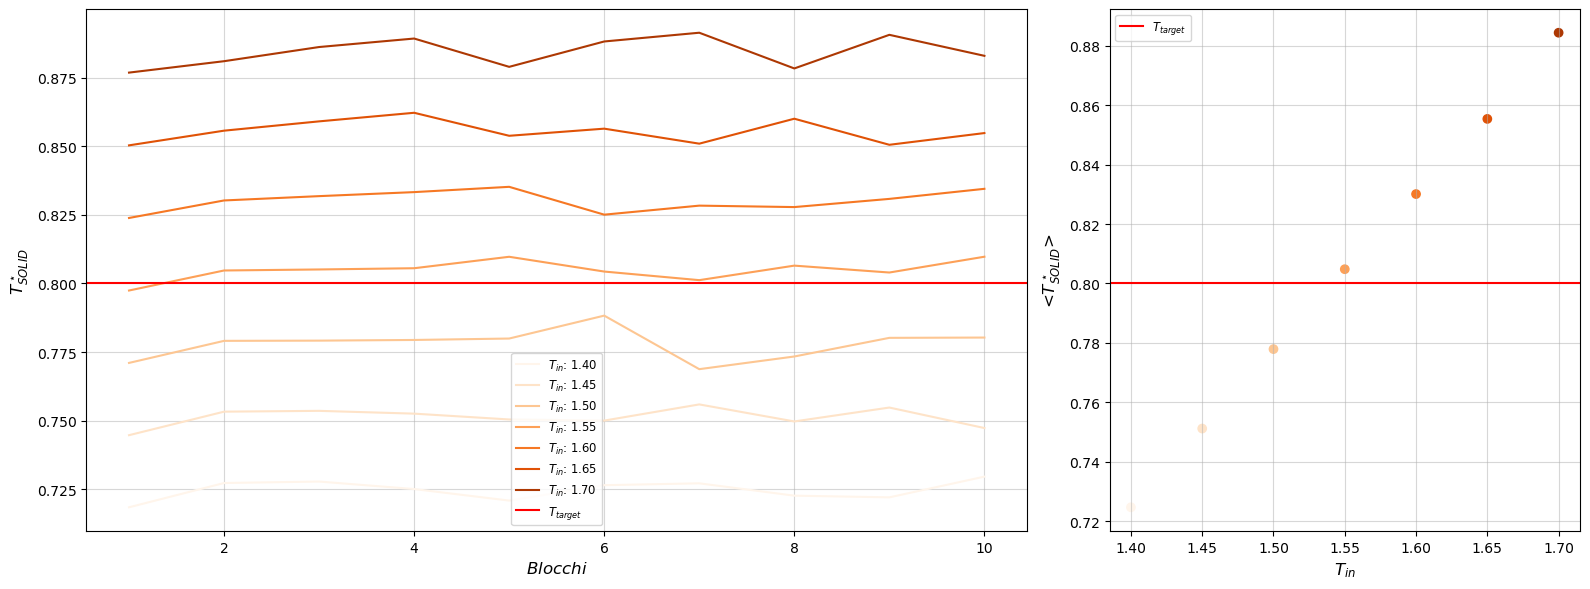

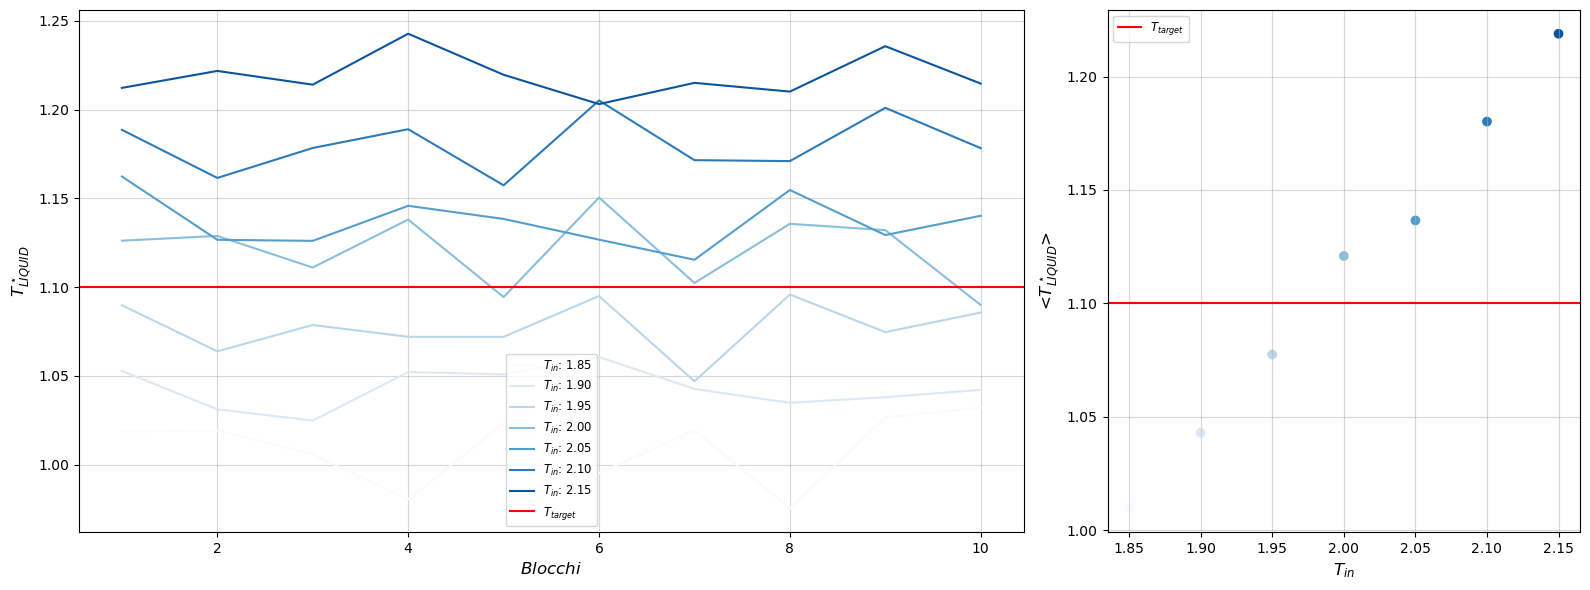

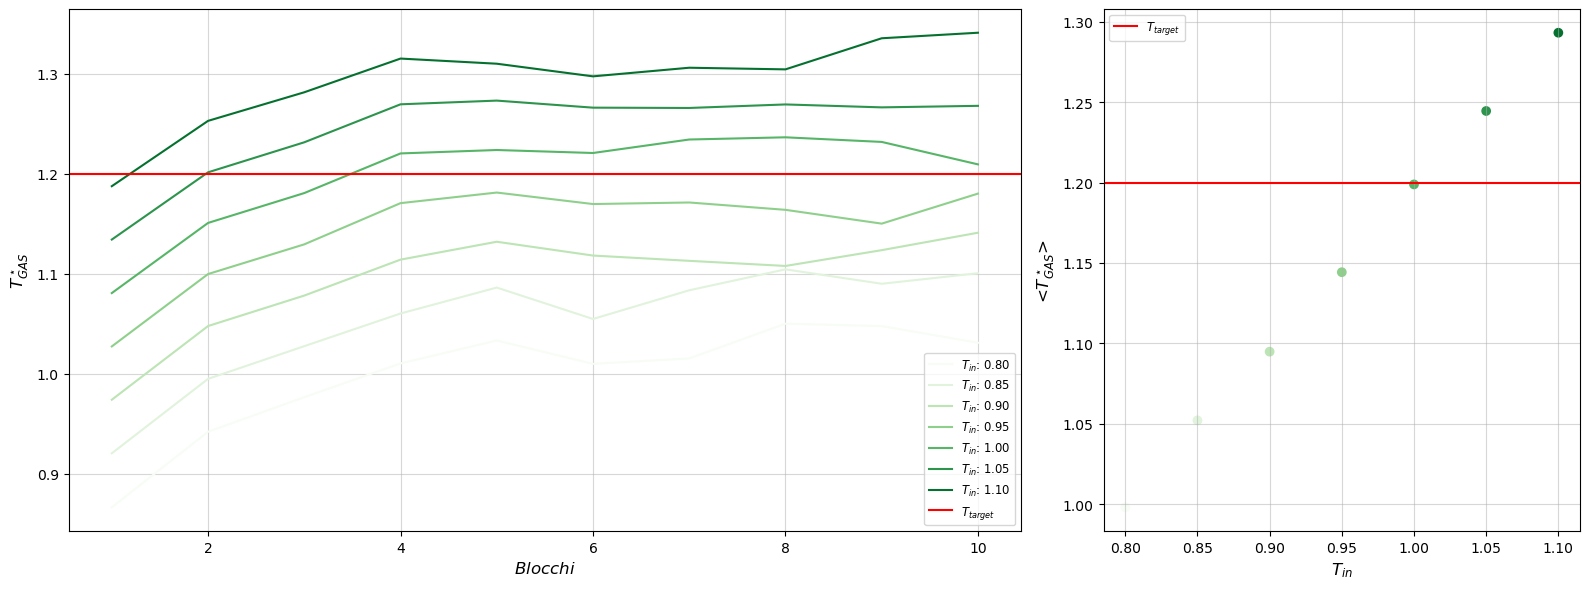

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

def read_data(filename):
    data = np.loadtxt(filename)
    x = data[:, 0]
    y = data[:, 1]
    return x, y

def compute_mean_y(y):
    return np.mean(y)

directories = ['SOLID', 'LIQUID', 'GAS']
colormaps = ['Oranges', 'Blues', 'Greens']
targets = [0.8, 1.1, 1.2]

for directory, cmap_name, target in zip(directories, colormaps, targets):
    file_list = sorted(glob.glob(f'/home/davide/Simulazione_Numerica/Esercizio_04/NSL_SIMULATOR/OUTPUT/{directory}/temperature_*.dat'))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / len(file_list)) for i in range(len(file_list))]

    mean_values = []
    temp_values = []

    for idx, filename in enumerate(file_list):
        x, y = read_data(filename)
        temperature_value = float(re.search(r'temperature_(\d+\.\d+)', filename).group(1))
        temp_values.append(temperature_value)

        label = os.path.basename(filename).replace('temperature_', '').replace('.dat', '')
        label = f'$T_{{in}}$: {label}'
        ax1.plot(x, y, label=label, color=colors[idx])

        mean_y = compute_mean_y(y)
        mean_values.append(mean_y)

    ax1.axhline(y=target, color="r", label="$T_{target}$")

    ax1.legend(loc='best', fontsize='small')
    ax1.set_xlabel('$Blocchi$', fontsize=12)
    ax1.set_ylabel(f'$T_{{{directory}}}^\star$', fontsize=12)
    ax1.grid(True, alpha=0.5)

    ax2.scatter(temp_values, mean_values, color=colors)
    ax2.axhline(y=target, color="r", label="$T_{target}$")
    ax2.legend(loc='best', fontsize='small')
    ax2.set_xlabel('$T_{in}$', fontsize=12)
    ax2.set_ylabel(f'<$T_{{{directory}}}^\star$>', fontsize=12)
    ax2.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

Dopodichè ho fatto iniziare ciascuna simulazione dopo un certo numero di step a vuoto perchè la temperatura arrivasse a regime, in particolare 1000 per la fase solida, 5000 per quella liquida e 20000 per quella gassosa. L'aumento di step necessari all'equilibrazione è spiegabile dalla minore interazione che si ha tra le particelle nella fase gassosa e in quella liquida.

Ho aggiunto nei file di input una string che smistasse l'output in cartelle diverse a seconda della fase in cui sto simulando il mio sistema.

Di seguito sono riportate le stime di energia totale per particella $E/N$, energia potenziale per particella $U/N$, energia cinetica per particella $K/N$, temperatura $T$, e pressione $P$ per i tre stati di fase (solido in arancione, liquido in blu e gassoso in verde).

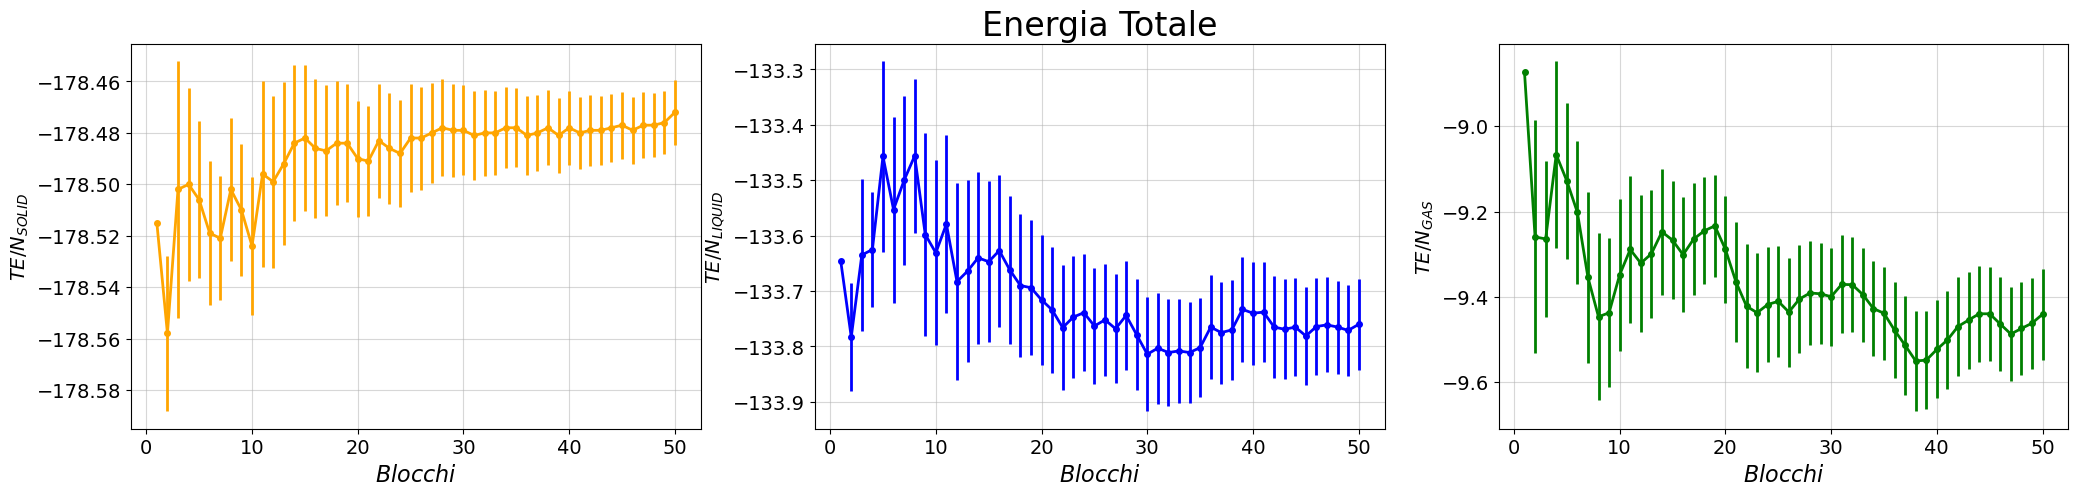

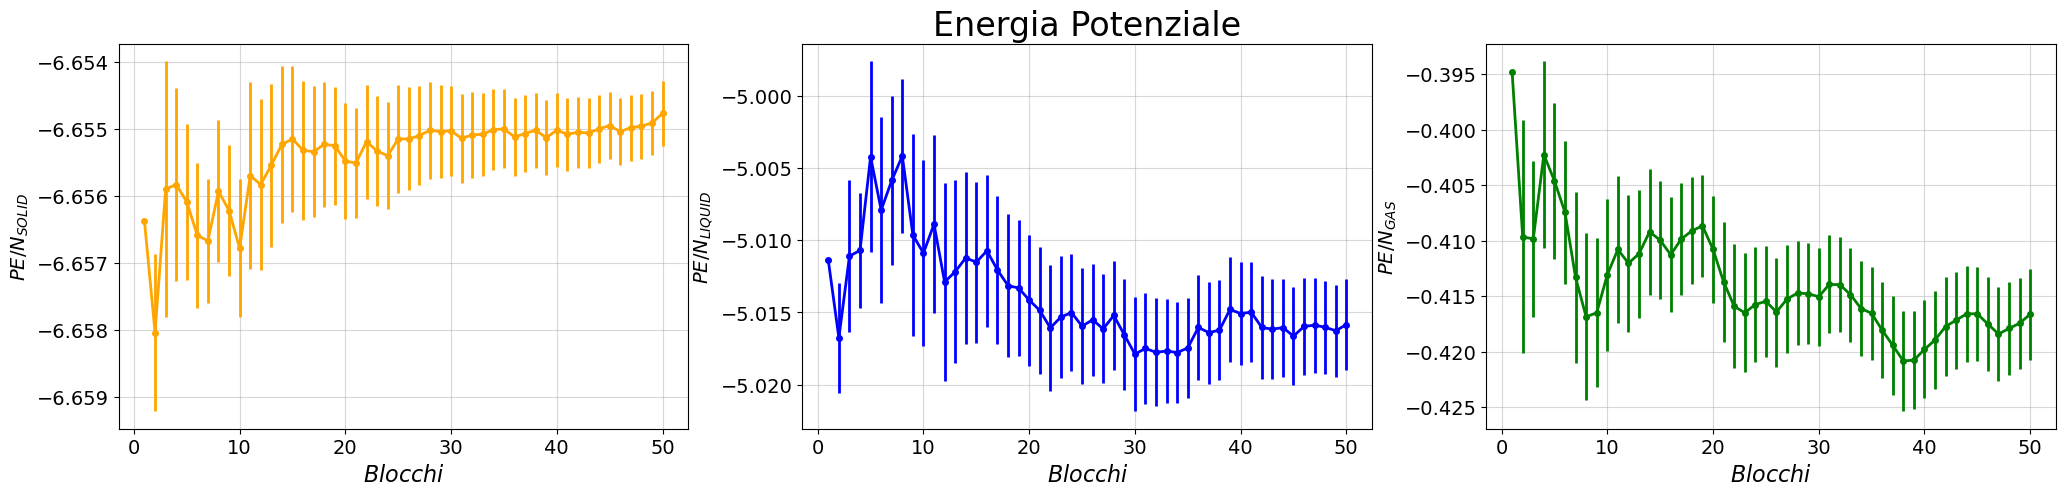

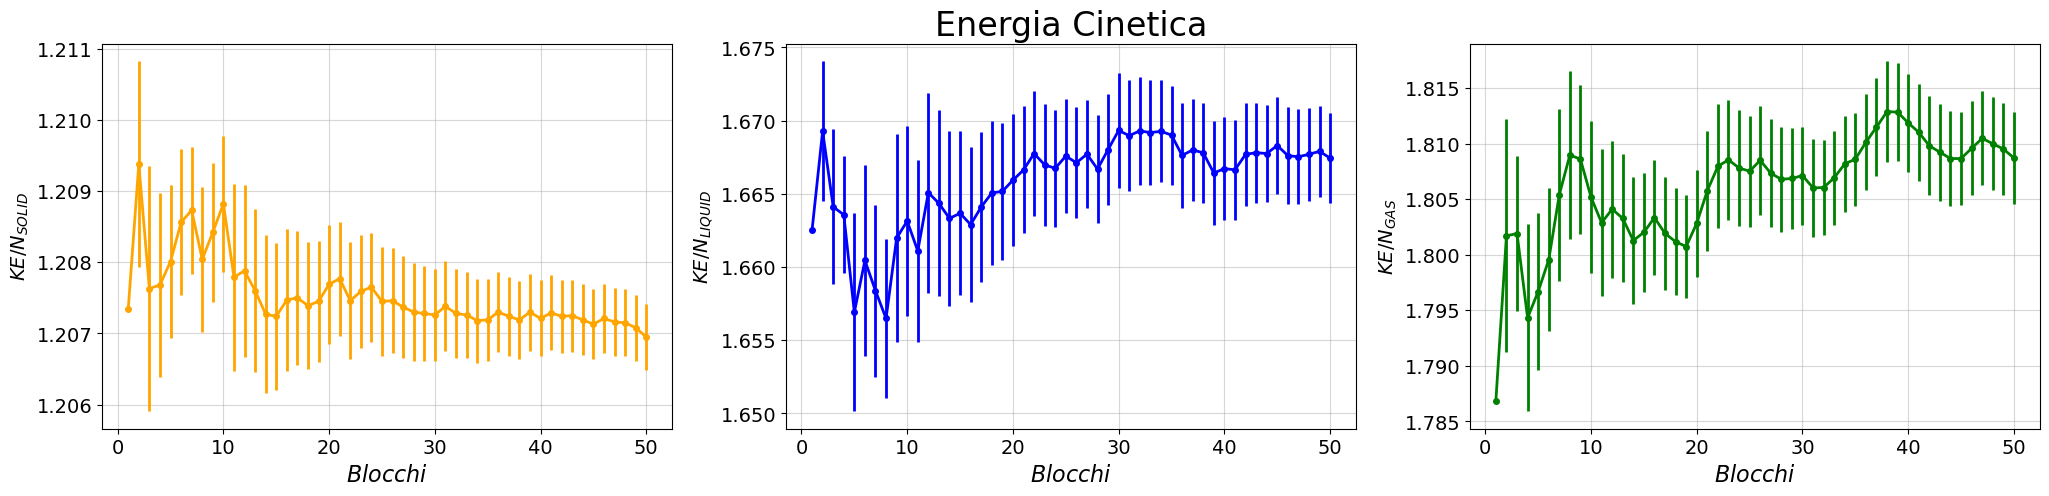

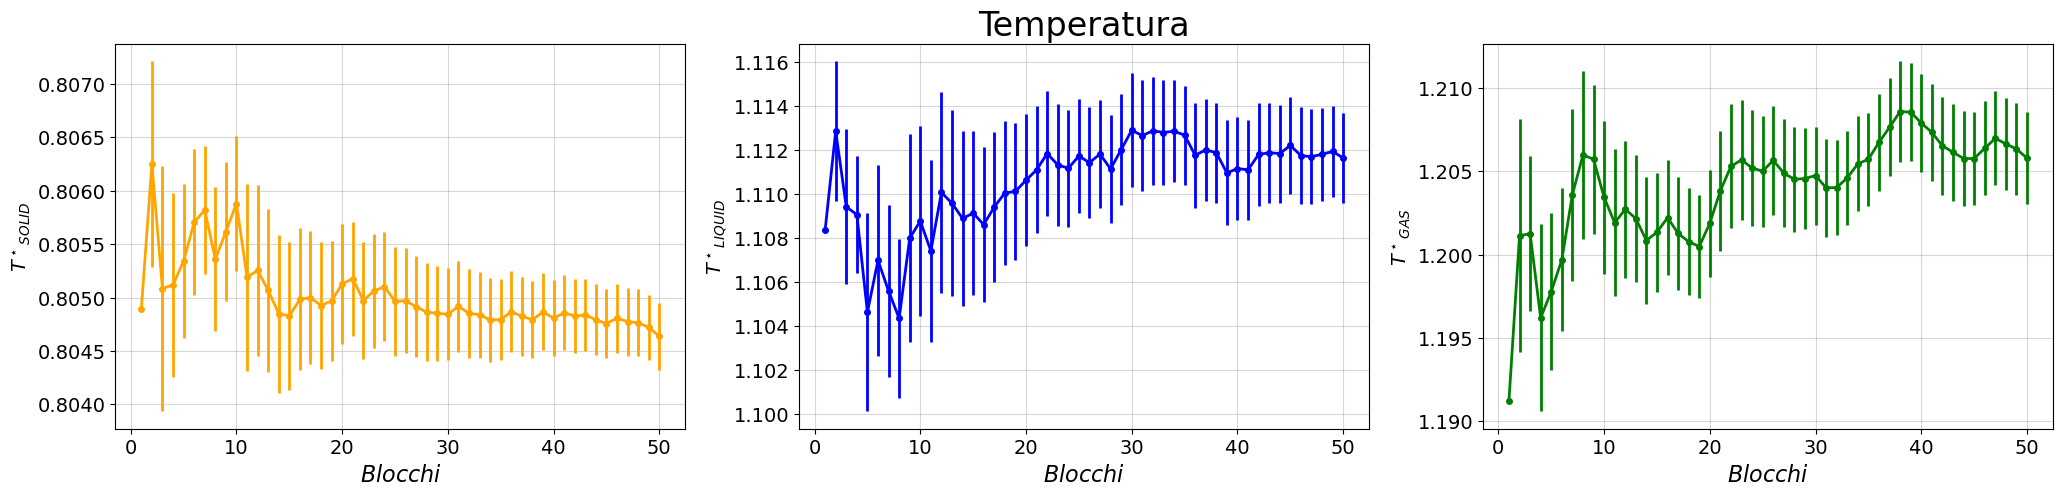

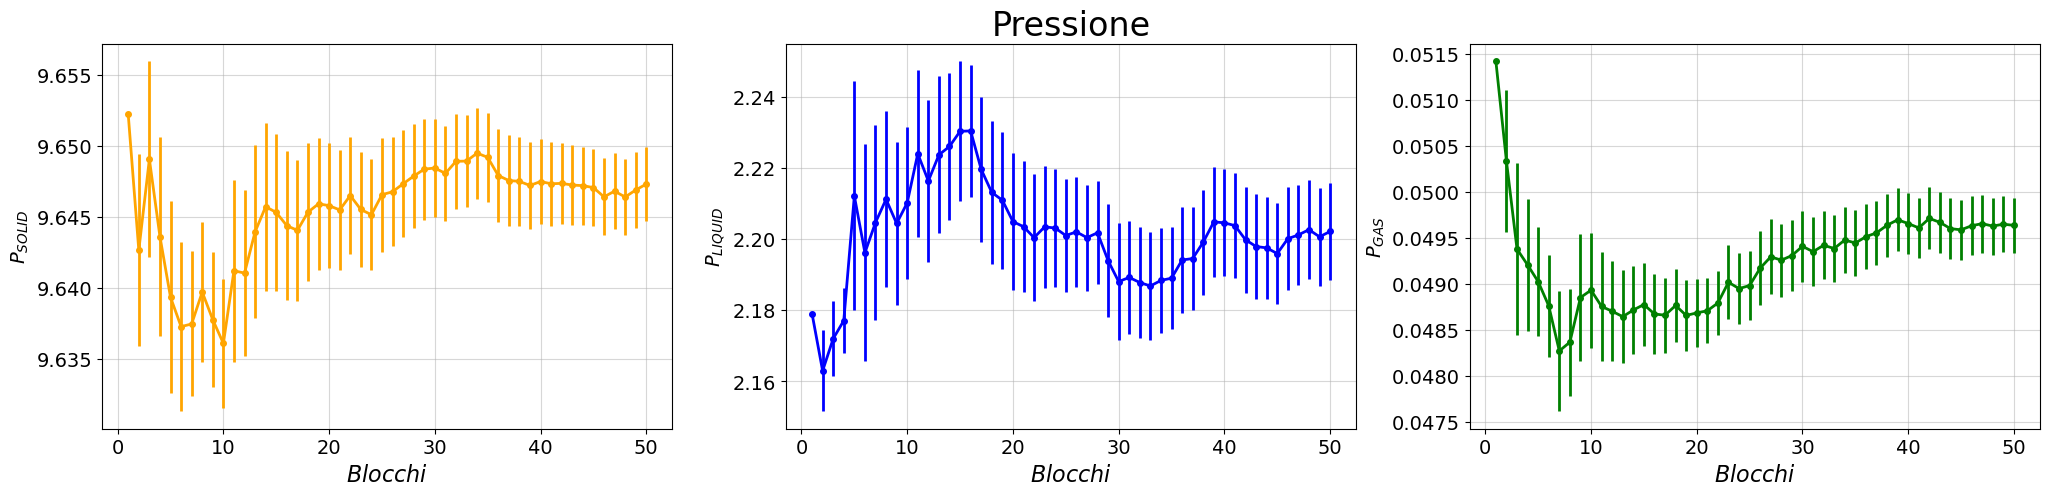

In [1]:
import scipy
from scipy.special import erf
import numpy as np
from numpy import exp
from numpy.lib.scimath import log, sqrt
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd

def Plot_Quantities(name, abbreviation, label, title):
    plt.figure(figsize=(25, 5))
    
    SOLID = pd.read_csv("/home/davide/Simulazione_Numerica/Esercizio_04/NSL_SIMULATOR/OUTPUT/SOLID/" + name + ".dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_' + abbreviation, abbreviation+ '_AVE', 'ERROR'])
    data_solid = SOLID[abbreviation+ '_AVE']
    error_solid = SOLID['ERROR']
    LIQUID = pd.read_csv("/home/davide/Simulazione_Numerica/Esercizio_04/NSL_SIMULATOR/OUTPUT/LIQUID/" + name + ".dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_' + abbreviation, abbreviation+ '_AVE', 'ERROR'])
    data_liquid = LIQUID[abbreviation+ '_AVE']
    error_liquid = LIQUID['ERROR']
    GAS = pd.read_csv("/home/davide/Simulazione_Numerica/Esercizio_04/NSL_SIMULATOR/OUTPUT/GAS/" + name + ".dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_' + abbreviation, abbreviation+ '_AVE', 'ERROR'])
    data_gas = GAS[abbreviation+ '_AVE']
    error_gas = GAS['ERROR']
    x = SOLID['BLOCK']

    plt.subplot(1, 3, 1)
    plt.errorbar(x,data_solid,yerr=error_solid, linewidth=2, color='orange', marker='o', markersize=4)
    plt.xlabel('$Blocchi$', fontsize=16)
    plt.ylabel(f'{label}$_{{SOLID}}$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.subplot(1, 3, 2)
    plt.errorbar(x,data_liquid,yerr=error_liquid, linewidth=2, color='blue', marker='o', markersize=4)
    plt.xlabel('$Blocchi$', fontsize=16)
    plt.ylabel(f'{label}$_{{LIQUID}}$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.title(title, fontsize=24)
    plt.subplot(1, 3, 3)
    plt.errorbar(x,data_gas,yerr=error_gas, linewidth=2, color='green', marker='o', markersize=4)
    plt.xlabel('$Blocchi$', fontsize=16)
    plt.ylabel(f'{label}$_{{GAS}}$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, alpha=0.5)

Plot_Quantities('total_energy', 'TE', '$TE/N$', 'Energia Totale')
Plot_Quantities('potential_energy', 'PE', '$PE/N$', 'Energia Potenziale')
Plot_Quantities('kinetic_energy', 'KE', '$KE/N$', 'Energia Cinetica')
Plot_Quantities('temperature', 'T', '$T^\star$', 'Temperatura')
Plot_Quantities('pressure', 'P', '$P$', 'Pressione')